In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# AI pipeline for image segmentation and object analysis

# Step 1: Image Segmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
#Load and preprocess the image:

In [ ]:
from PIL import Image
import torchvision.transforms as T

In [ ]:
image = Image.open("/content/drive/MyDrive/file 2.jpg")
transform = T.Compose([T.ToTensor()])
image_tensor = transform(image)

In [ ]:
import torchvision.models as models
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights

# Load a Mask R-CNN model with specific weights
model = models.detection.maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1)
model.eval()
# Check if GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 110MB/s] 


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
with torch.no_grad():
    predictions = model([image_tensor])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(image, predictions, threshold=0.5):
    plt.imshow(image)
    for i, mask in enumerate(predictions[0]['masks']):
        if predictions[0]['scores'][i] > threshold:
            mask = mask[0].mul(255).byte().cpu().numpy()
            plt.imshow(mask, alpha=0.5)
    plt.show()


In [ ]:
#Visualize segmented objects:

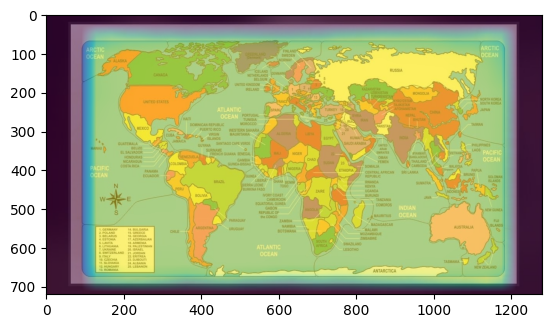

In [ ]:
visualize_predictions(image, predictions)

visualize_predictions(image, predictions)

# Step 2:  Object Extraction and Storage

In [ ]:
import os

def save_segmented_objects(image, predictions, output_dir="segmented_objects", threshold=0.5):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, mask in enumerate(predictions[0]['masks']):
        if predictions[0]['scores'][i] > threshold:
            mask = mask[0].mul(255).byte().cpu().numpy()
            masked_image = np.array(image) * mask[:, :, np.newaxis]
            object_image = Image.fromarray(masked_image.astype(np.uint8))
            object_image.save(os.path.join(output_dir, f"object_{i}.png"))
            print(f"Saved object_{i}.png")


In [ ]:
save_segmented_objects(image, predictions)

Saved object_0.png


save_segmented_objects(image, predictions)

# Step 3: Object Identification

In [ ]:
! pip install transformers


In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:

def describe_objects(output_dir="segmented_objects"):
    descriptions = {}
    for filename in os.listdir(output_dir):
        if filename.endswith(".png"):
            image_path = os.path.join(output_dir, filename)
            image = Image.open(image_path)
            inputs = processor(images=image, return_tensors="pt")
            outputs = model.get_text_features(**inputs)
            text = model.generate(inputs)
            descriptions[filename] = text

    return descriptions
    object_descriptions = describe_objects()



# Step 4: Text/Data Extraction from Objects

In [ ]:
pip install pytesseract

In [ ]:
import pytesseract

In [ ]:
!sudo apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,988 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:

def extract_text_from_objects(output_dir="segmented_objects"):
    texts = {}
    for filename in os.listdir(output_dir):
        if filename.endswith(".png"):
            image_path = os.path.join(output_dir, filename)
            text = pytesseract.image_to_string(image_path)
            texts[filename] = text

    return texts
object_texts = extract_text_from_objects()


# Step 5: Summarize Object Attributes

In [ ]:

from transformers import pipeline

summarizer = pipeline("summarization")

def summarize_object_attributes(object_texts):
    summaries = {}
    for filename, text in object_texts.items():
        summary = summarizer(text, max_length=50, min_length=25, do_sample=False)
        summaries[filename] = summary[0]['summary_text']

    return summaries

object_summaries = summarize_object_attributes(object_texts)


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

# Step 6: Data Mapping

In [ ]:
import json
import os

def create_data_mapping(object_descriptions, object_texts, object_summaries, output_dir="segmented_objects"):
    data_mapping = {}

    try:
        for filename in os.listdir(output_dir):
            if filename.endswith(".png"):
                object_id = filename.split(".")[0]
                data_mapping[object_id] = {
                    "description": object_descriptions.get(filename, ""),
                    "text": object_texts.get(filename, ""),
                    "summary": object_summaries.get(filename, "")
                }

        with open("data_mapping.json", "w") as f:
            json.dump(data_mapping, f, indent=4)
    except FileNotFoundError as e:
        print(f"Error: Directory not found: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Example usage
object_descriptions = {"object1.png": "description1", "object2.png": "description2"}
object_texts = {"object1.png": "text1", "object2.png": "text2"}
object_summaries = {"object1.png": "summary1", "object2.png": "summary2"}

create_data_mapping(object_descriptions, object_texts, object_summaries)

# Step 7: Output Generation

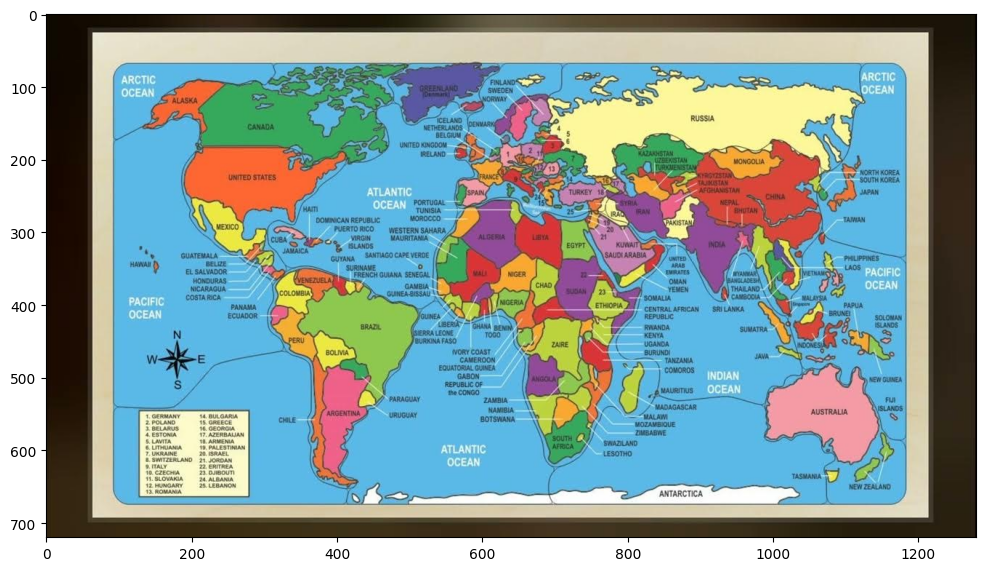

In [ ]:

import pandas as pd

def generate_final_output(image, data_mapping):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)
    table_data = []

    for object_id, data in data_mapping.items():
        table_data.append([object_id, data["description"], data["text"], data["summary"]])
        # Here you would add code to annotate the image with object IDs

    table = pd.DataFrame(table_data, columns=["Object ID", "Description", "Text", "Summary"])
    table.to_csv("object_data.csv", index=False)

    plt.show()

with open("data_mapping.json") as f:
    data_mapping = json.load(f)

generate_final_output(image, data_mapping)


# streamlit

In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


In [ ]:
pip install opencv-python-headless pillow pandas

In [ ]:
import streamlit as st
from PIL import Image
import pandas as pd
import cv2
import json
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

In [ ]:
st.title("AI Pipeline for Image Segmentation and Object Analysis")

uploaded_file = st.file_uploader("World_map", type="jpg")
if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image', use_column_width=True)
    st.write("")
    st.write("Segmenting image...")

In [ ]:
st.title("AI Pipeline for Image Segmentation and Object Analysis")

uploaded_file = st.file_uploader("/content/drive/MyDrive/file 2.jpg", type="jpg")
if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image', use_column_width=True)
    st.write("")
    st.write("Segmenting image...")

In [ ]:
if uploaded_file is not None:
    # Dummy function for segmentation
    segmented_objects, master_id = segment_image(image)

    # Display segmented objects
    st.image(segmented_objects, caption='Segmented Objects', use_column_width=True)

In [ ]:
if uploaded_file is not None:
    object_images = extract_objects(segmented_objects)

    for idx, obj in enumerate(object_images):
        st.image(obj, caption=f'Object {idx+1}', use_column_width=True)

In [ ]:
if uploaded_file is not None:
    identified_objects = identify_objects(object_images)

    for idx, desc in enumerate(identified_objects):
        st.write(f"Object {idx+1}: {desc}")

In [ ]:
if uploaded_file is not None:
    extracted_texts = extract_text(object_images)

    for idx, text in enumerate(extracted_texts):
        st.write(f"Object {idx+1} Text: {text}")

In [ ]:
if uploaded_file is not None:
    summaries = summarize_attributes(identified_objects, extracted_texts)

    for idx, summary in enumerate(summaries):
        st.write(f"Object {idx+1} Summary: {summary}")

In [ ]:
if uploaded_file is not None:
    # Create a DataFrame for the table
    data = {
        'Object ID': range(1, len(object_images) + 1),
        'Description': identified_objects,
        'Extracted Text': extracted_texts,
        'Summary': summaries
    }

    df = pd.DataFrame(data)
    st.write("Summary Table")
    st.dataframe(df)

    # Assuming you have a function to generate the final image with annotations
    annotated_image = generate_annotated_image(image, segmented_objects)
    st.image(annotated_image, caption='Annotated Image', use_column_width=True)

In [1]:
streamlit run app.py

SyntaxError: invalid syntax (3737097518.py, line 1)